In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
try:
    import tensorflow as tf
    print("TensorFlow version:", tf.__version__)
except ImportError:
    print("⚐ TensorFlow is not installed. Please install it using 'pip install tensorflow' and restart the environment.")
    exit(1)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Input
import joblib
import matplotlib.pyplot as plt

TensorFlow version: 2.18.0


In [3]:
# Step 1: Load Cycles Using Metadata
def load_cycles(csv_folder, metadata_path):
    print(f"Loading metadata from {metadata_path}...")
    cycles = []
    try:
        if metadata_path.lower().endswith('.csv'):
            metadata_df = pd.read_csv(metadata_path)
        elif metadata_path.lower().endswith(('.xlsx', '.xls')):
            metadata_df = pd.read_excel(metadata_path)
        else:
            print(f"⚐ Unsupported metadata file format: {metadata_path}. Exiting.")
            return cycles
    except FileNotFoundError:
        print(f"⚐ Metadata file {metadata_path} not found. Exiting.")
        return cycles
    except Exception as e:
        print(f"⚐ Error reading metadata: {e}. Exiting.")
        return cycles

    print(f"Metadata contents:\n{metadata_df.head()}")
    if 'filename' not in metadata_df.columns or 'type' not in metadata_df.columns or 'battery_id' not in metadata_df.columns:
        print(f"⚐ Metadata file {metadata_path} lacks required columns (filename, type, battery_id). Available columns: {metadata_df.columns.tolist()}")
        return cycles

    b0005_metadata = metadata_df[metadata_df['battery_id'] == 'B0005']
    if b0005_metadata.empty:
        print(f"⚐ No entries found for battery_id B0005 in metadata. Exiting.")
        return cycles

    valid_files = set(b0005_metadata['filename'].values)
    print(f"Valid files for B0005: {valid_files}")

    all_files = os.listdir(csv_folder)
    b0005_files = [f for f in all_files if f in valid_files]
    print(f"Files found in {csv_folder} matching B0005 metadata: {b0005_files}")

    for file in b0005_files:
        file_path = os.path.join(csv_folder, file)
        try:
            df = pd.read_csv(file_path)
            column_map = {
                'time': ['time', 'Time', 'TIME', 't'],
                'current': ['current', 'Current_measured', 'CURRENT', 'Sense_current', 'Battery_current'],
                'voltage': ['voltage', 'Voltage_measured', 'VOLTAGE', 'v'],
                'impedance': ['Battery_impedance', 'Rectified_Impedance', 'Re']
            }
            time_col = next((col for col in column_map['time'] if col in df.columns), None)
            current_col = next((col for col in column_map['current'] if col in df.columns), None)
            voltage_col = next((col for col in column_map['voltage'] if col in df.columns), None)
            impedance_col = next((col for col in column_map['impedance'] if col in df.columns), None)

            file_type = b0005_metadata[b0005_metadata['filename'] == file]['type'].iloc[0]
            if file_type in ['charge', 'discharge']:
                if not all([time_col, current_col, voltage_col]):
                    print(f"⚐ Error loading file {file}: Required columns (Time, Current, Voltage) not found. Available columns: {df.columns.tolist()}")
                    continue
                df = df[[time_col, current_col, voltage_col]].rename(columns={
                    time_col: 'Time',
                    current_col: 'Current_measured',
                    voltage_col: 'Voltage_measured'
                })
                if file_type == 'discharge':
                    dt = np.diff(np.insert(df['Time'].values, 0, 0))
                    current = df['Current_measured'].values
                    charge = np.sum(current * dt)
                    capacity = abs(charge) / 3600
                    cycle_index = b0005_metadata[b0005_metadata['filename'] == file]['cycle_index'].iloc[0] if 'cycle_index' in metadata_df.columns else 0
                    cycles.append({
                        'filename': file,
                        'type': 'discharge',
                        'data': df,
                        'capacity': capacity,
                        're': 0.1,
                        'cycle_index': cycle_index
                    })
                else:
                    cycle_index = b0005_metadata[b0005_metadata['filename'] == file]['cycle_index'].iloc[0] if 'cycle_index' in metadata_df.columns else 0
                    cycles.append({
                        'filename': file,
                        'type': 'charge',
                        'data': df,
                        'capacity': 0.0,
                        're': 0.1,
                        'cycle_index': cycle_index
                    })
            elif file_type == 'impedance':
                if not impedance_col:
                    print(f"⚐ Error loading file {file}: Required impedance column not found. Available columns: {df.columns.tolist()}")
                    continue
                if df[impedance_col].dtype == 'object':
                    def parse_complex(s):
                        try:
                            return complex(s).real if isinstance(s, str) else float(s)
                        except ValueError:
                            return np.nan
                    df[impedance_col] = df[impedance_col].apply(parse_complex)
                re = df[impedance_col].mean() if not df[impedance_col].isna().all() else 0.1
                r1 = re * 0.4
                r2 = re * 0.6
                c1 = 2000 / (re / r1) if re > 0 else 2000
                c2 = 5000 / (re / r2) if re > 0 else 5000
                cycle_index = b0005_metadata[b0005_metadata['filename'] == file]['cycle_index'].iloc[0] if 'cycle_index' in metadata_df.columns else 0
                cycles.append({
                    'filename': file,
                    'type': 'impedance',
                    'data': df,
                    'capacity': 0.0,
                    're': re,
                    'r1': r1,
                    'r2': r2,
                    'c1': c1,
                    'c2': c2,
                    'cycle_index': cycle_index
                })
            else:
                print(f"⚐ Unknown type {file_type} for file {file}. Skipping.")
        except Exception as e:
            print(f"⚐ Error loading file {file}: {e}")
    return cycles

In [5]:
# Step 2: Load and Preprocess Data for ML
def load_data_for_ml(cycles, sequence_length=64, max_rows=100000):
    X, y_soc = [], []
    scaler = MinMaxScaler()
    valid_cycle_count = 0
    total_rows = 0
    for cycle in cycles:
        if cycle['type'] == 'impedance':
            continue
        df = cycle['data']
        print(f"Processing cycle {cycle['filename']} with length {len(df)}")
        if len(df) < sequence_length:
            print(f"⚐ Skipping cycle {cycle['filename']}: Insufficient data length ({len(df)} < {sequence_length})")
            continue
        valid_cycle_count += 1
        capacity = cycle['capacity'] if cycle['type'] == 'discharge' else 2.0
        time = df['Time'].values
        current = df['Current_measured'].values
        voltage = df['Voltage_measured'].values
        dt = np.diff(np.insert(time, 0, 0))
        charge = np.cumsum(current * dt)
        if cycle['type'] == 'discharge':
            soc = 1 - charge / (capacity * 3600)
        else:
            soc = charge / (capacity * 3600)
        soc = np.clip(soc, 0, 1)
        features = np.vstack((voltage, current, time)).T
        if total_rows + len(features) > max_rows:
            features = features[:max_rows - total_rows]
            soc = soc[:max_rows - total_rows]
        X.append(features)
        y_soc.append(soc)
        total_rows += len(features)
        if total_rows >= max_rows:
            break
    print(f"Number of valid cycles for ML: {valid_cycle_count}")
    if not X or not y_soc:
        print("⚐ No valid data for ML processing. Check cycle data.")
        return None, None, None, None
    X = np.vstack(X)
    y_soc = np.hstack(y_soc)
    X_scaled = scaler.fit_transform(X)
    joblib.dump(scaler, 'scaler_x.pkl')
    print(f"X_scaled shape: {X_scaled.shape}, y_soc shape: {y_soc.shape}")
    return X_scaled, y_soc, scaler, cycles

In [7]:
# Step 3: Prepare Sequences for LSTM
def prepare_sequences(X, y, sequence_length=64, batch_size=16):
    X_seq, y_seq = [], []
    for i in range(0, len(X) - sequence_length + 1, batch_size):
        if i + sequence_length > len(X):
            break
        X_seq.append(X[i:i + sequence_length])
        y_seq.append(y[i + sequence_length - 1])
    return np.array(X_seq), np.array(y_seq)

In [9]:
# Step 4: Train LSTM Model
def train_lstm(X, y, sequence_length=64):
    if X.shape[0] < sequence_length:
        print(f"⚐ Insufficient data for LSTM training (length {X.shape[0]} < {sequence_length}). Exiting.")
        return None
    X_seq, y_seq = prepare_sequences(X, y, sequence_length, batch_size=16)
    if X_seq.size == 0 or y_seq.size == 0:
        print("⚐ No sequences prepared for LSTM training. Check data.")
        return None
    print(f"Training LSTM with X_seq shape: {X_seq.shape}, y_seq shape: {y_seq.shape}")
    inputs = Input(shape=(sequence_length, X.shape[1]))
    x = LSTM(50, activation='relu')(inputs)
    outputs = Dense(1)(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse')
    print("Starting model fitting...")
    history = model.fit(X_seq, y_seq, epochs=5, batch_size=16, validation_split=0.2, verbose=1)
    for epoch, (train_loss, val_loss) in enumerate(zip(history.history['loss'], history.history['val_loss']), 1):
        print(f"Epoch {epoch}: Training Loss = {train_loss:.4f}, Validation Loss = {val_loss:.4f}")
    return model

In [19]:
# Step 5: ECM and EKF Implementation
def ecm_model(state, current, params, dt, transition_threshold=1.0):
    soc, v1, v2 = state
    r0, r1, r2, c1, c2 = params['r0'], params['r1'], params['r2'], params['c1'], params['c2']
    # Adjusted OCV model with cubic term for low SOC
    ocv = 3.4 + 0.9 * soc - 0.1 * soc**2 + 0.05 * soc**3 if soc < 0.1 else 3.4 + 0.9 * soc - 0.1 * soc**2
    dsoc_dt = -current / (params['capacity'] * 3600) if abs(current) > 0.01 else 0
    dv1_dt = -v1 / (r1 * c1) + current / c1
    dv2_dt = -v2 / (r2 * c2) + current / c2
    soc_next = soc + dsoc_dt * dt
    v1_next = v1 + dv1_dt * dt if abs(current) < transition_threshold or v1_next_prev is None else current * r1 * (1 - np.exp(-dt / (r1 * c1)))
    v2_next = v2 + dv2_dt * dt if abs(current) < transition_threshold or v2_next_prev is None else current * r2 * (1 - np.exp(-dt / (r2 * c2)))
    v_terminal = ocv - v1_next - v2_next - current * r0
    return np.array([soc_next, v1_next, v2_next]), v_terminal

def ekf_step(state, P, current, v_measured, params, dt, Q, R, cumulative_charge=0, prev_current=None):
    global v1_next_prev, v2_next_prev
    state_pred, v_pred = ecm_model(state, current, params, dt)
    F = np.array([[1, 0, 0],
                  [0, 1 - dt / (params['r1'] * params['c1']), 0],
                  [0, 0, 1 - dt / (params['r2'] * params['c2'])]])
    P_pred = F @ P @ F.T + Q
    d_ocv_d_soc = 0.9 - 0.2 * state[0] + 0.15 * state[0]**2 if state[0] < 0.1 else 0.9 - 0.2 * state[0]
    H = np.array([d_ocv_d_soc, -1, -1])
    innovation = v_measured - v_pred
    S = H @ P_pred @ H.T + R
    K = P_pred @ H.T / S if S != 0 else np.zeros(3)
    state_updated = state_pred + K * innovation
    # Allow temporary negative SOC for over-discharge, reset to 0 after validation
    if state_updated[0] < 0 and prev_current is not None and abs(current - prev_current) < 0.1:
        state_updated[0] = 0
        cumulative_charge += abs(current) * dt
    elif state_updated[0] > 1:
        state_updated[0] = 1
    # Adjust capacity if cumulative charge exceeds nominal capacity
    if cumulative_charge > params['capacity'] * 3600:
        params['capacity'] = max(1.0, params['capacity'] - 0.001 * cumulative_charge / 3600)  # Simple capacity fade
        cumulative_charge = 0
    v1_next_prev, v2_next_prev = state_updated[1], state_updated[2]
    return state_updated, P_pred, cumulative_charge

def plot_capacity_and_charging(cycles, times_discharge, soc_estimates_discharge, voltages_discharge, v_preds_discharge, times_charge=None, soc_estimates_charge=None, voltages_charge=None):
    # Capacity Graph
    capacities = []
    for cycle in cycles:
        if cycle['type'] == 'discharge':
            capacities.append(cycle['capacity'])
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(capacities)), capacities, label='Estimated Capacity (Ah)', marker='o')
    plt.xlabel('Cycle Index')
    plt.ylabel('Capacity (Ah)')
    plt.title('Battery Capacity Over Cycles')
    plt.legend()
    plt.grid(True)
    plt.show()  # Display plot instead of saving
    print("Capacity graph displayed.")

    # Charging Graph (if data exists)
    if times_charge is not None and soc_estimates_charge is not None and voltages_charge is not None:
        plt.figure(figsize=(12, 6))
        plt.plot(times_charge[1:], soc_estimates_charge, label='Estimated SOC (Charge)')
        plt.plot(times_charge[1:], voltages_charge[1:], label='Measured Voltage (Charge)', alpha=0.5)
        plt.xlabel('Time (s)')
        plt.ylabel('SOC / Voltage (V)')
        plt.title('SOC and Voltage During Charging')
        plt.legend()
        plt.grid(True)
        plt.show()  # Display plot instead of saving
        print("Charging graph displayed.")

    # Discharge Graph (for reference)
    plt.figure(figsize=(12, 6))
    plt.plot(times_discharge[1:], soc_estimates_discharge, label='Estimated SOC (Discharge)')
    plt.plot(times_discharge[1:], v_preds_discharge, label='Predicted Voltage (Discharge)', alpha=0.5)
    plt.plot(times_discharge[1:], voltages_discharge[1:], label='Measured Voltage (Discharge)', alpha=0.5)
    plt.xlabel('Time (s)')
    plt.ylabel('SOC / Voltage (V)')
    plt.title('SOC and Voltage Estimation (Discharge)')
    plt.legend()
    plt.grid(True)
    plt.show()  # Display plot instead of saving
    print("SOC and voltage estimation plot displayed.")

def plot_charge_soc(times_charge, soc_estimates_charge):
    if times_charge is not None and soc_estimates_charge is not None:
        plt.figure(figsize=(12, 6))
        plt.plot(times_charge[1:], soc_estimates_charge, label='Estimated SOC (Charge)', color='blue')
        plt.xlabel('Time (s)')
        plt.ylabel('SOC')
        plt.title('Estimated SOC During Charging')
        plt.legend()
        plt.grid(True)
        plt.show()  # Display plot instead of saving
        print("Estimated SOC for charging cycle displayed.")
    else:
        print("No charge cycle data available for plotting.")

Starting process with folder: D:\NASA_Battery_Dataset\cleaned_dataset\data and metadata: D:\NASA_Battery_Dataset\cleaned_dataset\metadata.csv
Loading metadata from D:\NASA_Battery_Dataset\cleaned_dataset\metadata.csv...
Metadata contents:
        type                                         start_time  \
0  discharge  [2010.       7.      21.      15.       0.    ...   
1  impedance  [2010.       7.      21.      16.      53.    ...   
2     charge  [2010.       7.      21.      17.      25.    ...   
3  impedance                    [2010    7   21   20   31    5]   
4  discharge  [2.0100e+03 7.0000e+00 2.1000e+01 2.1000e+01 2...   

   ambient_temperature battery_id  test_id  uid   filename  \
0                    4      B0047        0    1  00001.csv   
1                   24      B0047        1    2  00002.csv   
2                    4      B0047        2    3  00003.csv   
3                   24      B0047        3    4  00004.csv   
4                    4      B0047        4    5 

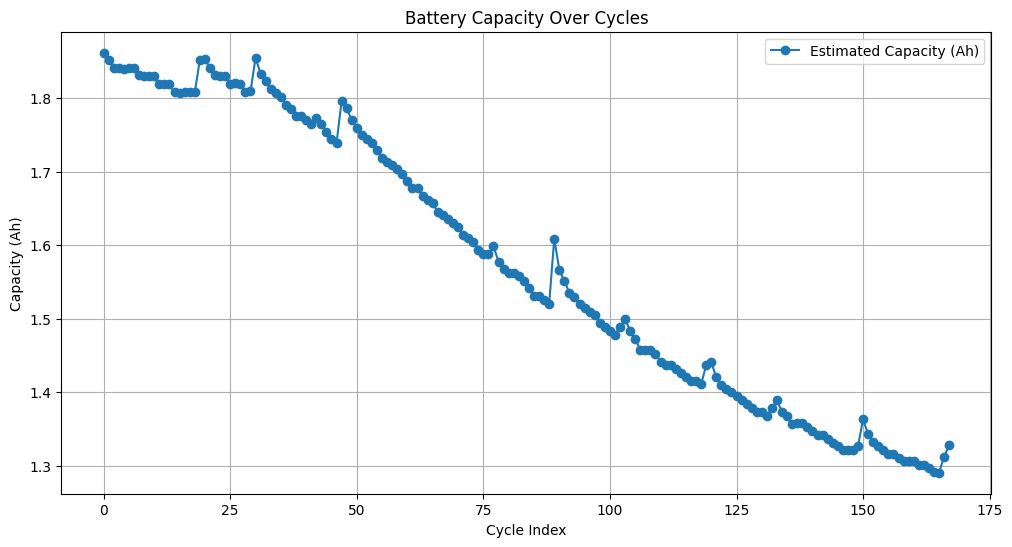

Capacity graph displayed.


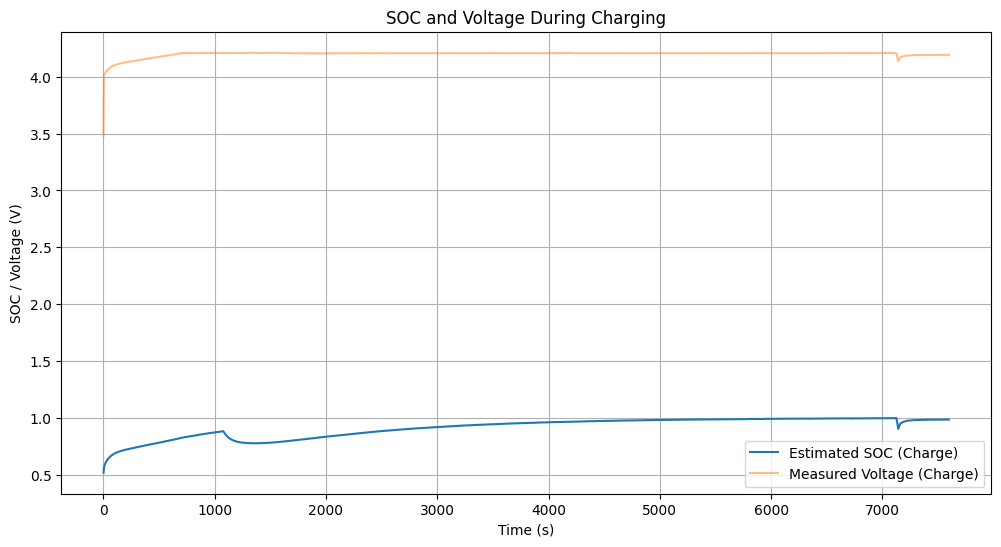

Charging graph displayed.


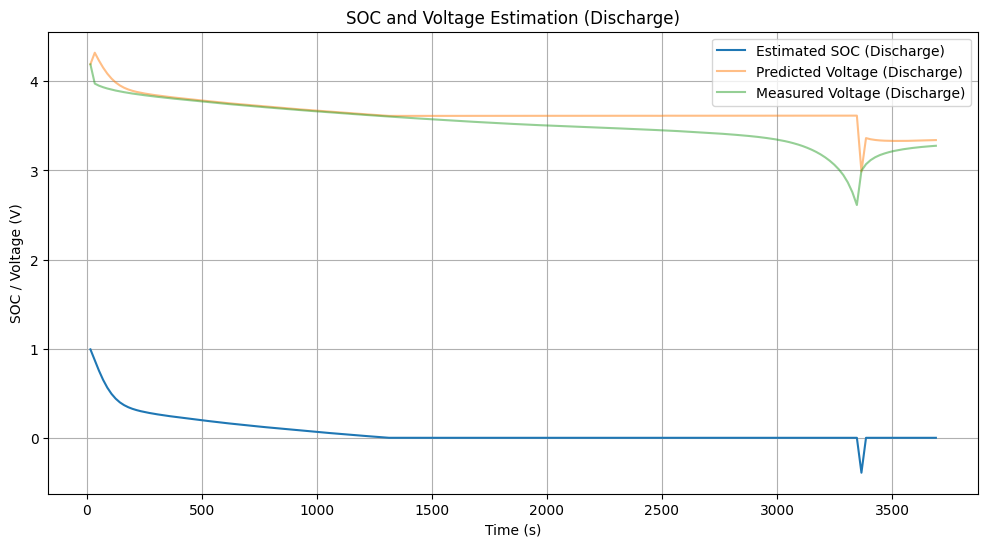

SOC and voltage estimation plot displayed.


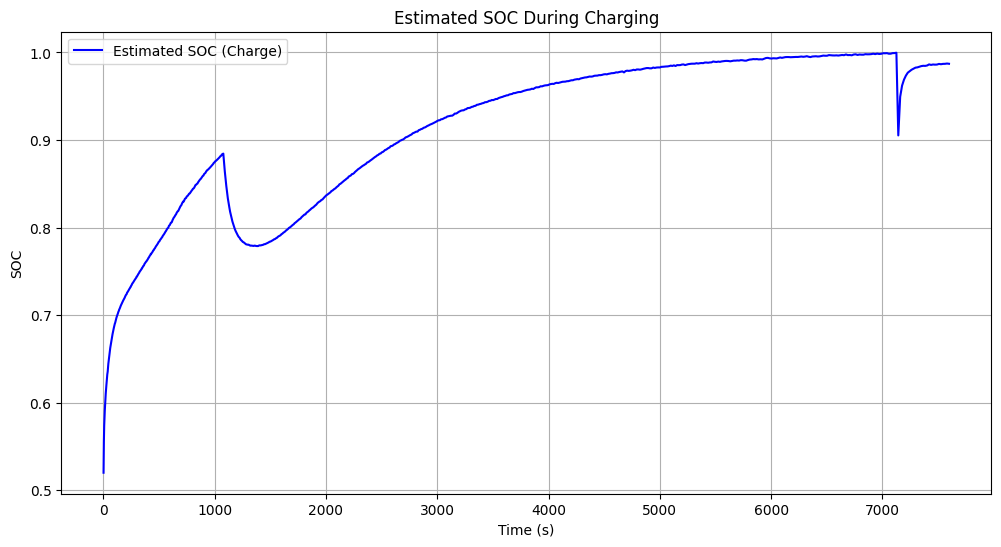

Estimated SOC for charging cycle displayed.


In [21]:
def main():
    csv_folder = r"D:\NASA_Battery_Dataset\cleaned_dataset\data"
    metadata_path = r"D:\NASA_Battery_Dataset\cleaned_dataset\metadata.csv"
    print(f"Starting process with folder: {csv_folder} and metadata: {metadata_path}")
    
    cycles = load_cycles(csv_folder, metadata_path)
    if not cycles:
        print("No cycles loaded. Check file paths, metadata columns, and file contents.")
        return
    
    X_scaled, y_soc, scaler, cycles = load_data_for_ml(cycles, max_rows=100000)
    if X_scaled is None or y_soc is None:
        print("ML data preparation failed. Exiting.")
        return
    
    print("Starting LSTM training...")
    soc_model = train_lstm(X_scaled, y_soc)
    if soc_model is None:
        print("LSTM training failed. Exiting.")
        return
    
    params = {'r0': 0.08, 'r1': 0.02, 'r2': 0.02, 'c1': 2000, 'c2': 5000, 'capacity': 1.9}
    state = np.array([0.9, 0.0, 0.0])
    P = np.eye(3) * 0.05  # Increased initial covariance for better convergence
    Q = np.eye(3) * 1e-2  # Process noise
    R = 0.05  # Measurement noise
    cumulative_charge = 0
    global v1_next_prev, v2_next_prev
    v1_next_prev, v2_next_prev = None, None
    
    discharge_cycles = [c for c in cycles if c['type'] == 'discharge']
    charge_cycles = [c for c in cycles if c['type'] == 'charge']
    if not discharge_cycles:
        print("⚐ No discharge cycles found. Exiting.")
        return
    
    # Process Discharge Cycle
    cycle = discharge_cycles[0]
    df = cycle['data']
    voltages_discharge = df['Voltage_measured'].values
    currents_discharge = df['Current_measured'].values
    if currents_discharge[0] >= 0:
        currents_discharge = -currents_discharge
    print(f"First current value (discharge): {currents_discharge[0]:.2f}")
    times_discharge = df['Time'].values
    params['capacity'] = cycle['capacity'] if cycle['capacity'] > 0 else 1.9
    
    if len(voltages_discharge) >= 64:
        features = np.vstack((voltages_discharge[:64], currents_discharge[:64], times_discharge[:64])).T
        features_scaled = scaler.transform(features)
        features_seq = features_scaled[-64:].reshape(1, 64, 3)
        initial_soc = np.clip(soc_model.predict(features_seq)[0][0], 0, 1)
        
        impedance_cycle = next((c for c in cycles if c['type'] == 'impedance' and c['cycle_index'] == cycle['cycle_index']), None)
        if impedance_cycle:
            params['r1'] = impedance_cycle['r1']
            params['r2'] = impedance_cycle['r2']
            params['c1'] = impedance_cycle['c1']
            params['c2'] = impedance_cycle['c2']
            print(f"Using impedance-derived r1: {params['r1']:.4f}, r2: {params['r2']:.4f}, c1: {params['c1']:.0f}, c2: {params['c2']:.0f}")
        else:
            print(f"No impedance data for cycle {cycle['cycle_index']}, using default values: r1={params['r1']}, r2={params['r2']}, c1={params['c1']}, c2={params['c2']}")
        
        dt0 = times_discharge[1] - times_discharge[0] if len(times_discharge) > 1 else 1.0
        i0 = currents_discharge[0]
        v0_measured = voltages_discharge[0]
        tau1 = params['r1'] * params['c1']
        tau2 = params['r2'] * params['c2']
        v1_initial = i0 * params['r1'] * (1 - np.exp(-dt0 / tau1))
        v2_initial = i0 * params['r2'] * (1 - np.exp(-dt0 / tau2))
        ocv_initial = v0_measured + i0 * params['r0'] + v1_initial + v2_initial
        a = -0.1
        b = 0.9
        c = 3.4 - ocv_initial
        d = b**2 - 4*a*c
        if d >= 0:
            soc1 = (-b + np.sqrt(d)) / (2*a)
            soc2 = (-b - np.sqrt(d)) / (2*a)
            if 0 <= soc1 <= 1:
                soc_from_ocv = soc1
            elif 0 <= soc2 <= 1:
                soc_from_ocv = soc2
            else:
                soc_from_ocv = 0.5
        else:
            soc_from_ocv = 0.5
        initial_soc = (initial_soc + soc_from_ocv) / 2
        
        state = np.array([initial_soc, v1_initial, v2_initial])
        _, v_terminal_initial = ecm_model(state, i0, params, dt0)
        print(f"Initial SOC from LSTM: {initial_soc:.2f}, v1: {v1_initial:.2f}, v2: {v2_initial:.2f}")
        print(f"Initial v_measured: {v0_measured:.2f}, v_terminal_pred: {v_terminal_initial:.2f}")
        if abs(v0_measured - v_terminal_initial) > 0.1:
            print(f"⚐ Warning: Initial v_terminal ({v_terminal_initial:.2f}) differs from v_measured ({v0_measured:.2f}) by more than 0.1V. Consider adjusting parameters.")
    
    soc_estimates_discharge = []
    v_preds_discharge = []
    prev_current = currents_discharge[0] if len(currents_discharge) > 0 else 0
    for t in range(1, len(voltages_discharge)):
        try:
            dt = times_discharge[t] - times_discharge[t-1]
            current = currents_discharge[t]
            v_measured = voltages_discharge[t]
            state, P, cumulative_charge = ekf_step(state, P, current, v_measured, params, dt, Q, R, cumulative_charge, prev_current)
            soc_estimates_discharge.append(state[0])
            _, v_pred = ecm_model(state, current, params, dt)
            v_preds_discharge.append(v_pred)
            residual = abs(v_measured - v_pred)
            if residual > 0.1:
                print(f"Warning: High residual {residual:.2f}V at time {times_discharge[t]:.2f}s")
            print(f"Time: {times_discharge[t]:.2f}s, SOC: {state[0]:.2f}, Current: {current:.2f}, Residual: {residual:.2f}V")
            prev_current = current
        except Exception as e:
            print(f"Error at index {t}: {e}")
            continue

    # Process Charge Cycle (if available)
    times_charge = None
    soc_estimates_charge = None
    voltages_charge = None
    if charge_cycles:
        charge_cycle = charge_cycles[0]
        df_charge = charge_cycle['data']
        voltages_charge = df_charge['Voltage_measured'].values
        currents_charge = df_charge['Current_measured'].values
        if currents_charge[0] <= 0:
            currents_charge = -currents_charge  # Assume charging current is positive
        print(f"First current value (charge): {currents_charge[0]:.2f}")
        times_charge = df_charge['Time'].values
        params['capacity'] = charge_cycle['capacity'] if charge_cycle['capacity'] > 0 else 1.9
        
        if len(voltages_charge) >= 64:
            features = np.vstack((voltages_charge[:64], currents_charge[:64], times_charge[:64])).T
            features_scaled = scaler.transform(features)
            features_seq = features_scaled[-64:].reshape(1, 64, 3)
            initial_soc = np.clip(soc_model.predict(features_seq)[0][0], 0, 1)
            
            state = np.array([initial_soc, 0.0, 0.0])
            cumulative_charge = 0
            soc_estimates_charge = []
            for t in range(1, len(voltages_charge)):
                try:
                    dt = times_charge[t] - times_charge[t-1]
                    current = currents_charge[t]
                    v_measured = voltages_charge[t]
                    state, P, cumulative_charge = ekf_step(state, P, current, v_measured, params, dt, Q, R, cumulative_charge)
                    soc_estimates_charge.append(state[0])
                except Exception as e:
                    print(f"Error at index {t} (charge): {e}")
                    continue

    # Plot Results
    plot_capacity_and_charging(cycles, times_discharge, soc_estimates_discharge, voltages_discharge, v_preds_discharge, times_charge, soc_estimates_charge, voltages_charge)
    plot_charge_soc(times_charge, soc_estimates_charge)
if __name__ == "__main__":
    main()